In [1]:
import numpy    as np
import pandas   as pd
import networkx as nx

import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors     import kneighbors_graph
from sklearn.metrics       import pairwise_distances


In [3]:
df = pd.read_csv("../data/processed/photometric_z0.2_sn_25.csv")
df.describe()

,Z,PSFMAG_u,PSFMAG_g,PSFMAG_r,PSFMAG_i,EXTINCTION_u,EXTINCTION_g,EXTINCTION_r,EXTINCTION_i,SN_MEDIAN_ALL,...,K_g,K_r,K_i,M_u,M_g,M_r,M_i,u_g,g_r,r_i
count,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,...,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000
mean,0.140403,17.945722,17.638720,17.325787,16.870387,0.183380,0.140161,0.098511,0.073713,35.772377,...,-0.013545,0.197070,-0.083992,-21.167651,-21.561781,-22.043679,-22.193219,0.394130,0.481898,0.149540
std,0.037791,1.116938,0.852890,0.699497,0.702433,0.116484,0.089696,0.062646,0.046772,8.539951,...,0.015801,0.052427,0.045392,1.431151,1.155085,0.998123,1.031657,0.389100,0.252820,0.125257
min,0.004153,14.247252,14.388747,14.459476,14.084700,0.017132,0.013349,0.009235,0.006862,25.013718,...,-0.045206,0.006158,-0.167864,-25.386094,-25.375982,-25.456783,-25.621219,-0.098113,0.038186,-0.185885
25%,0.116351,17.167489,17.104413,16.896029,16.429406,0.096848,0.074400,0.052032,0.038991,28.731733,...,-0.027215,0.150913,-0.125682,-22.063490,-22.225388,-22.594343,-22.757011,0.128925,0.292029,0.062663
50%,0.146000,17.944424,17.703041,17.422628,16.957796,0.160177,0.121237,0.085881,0.064816,33.920502,...,-0.013124,0.185359,-0.083560,-21.468693,-21.755971,-22.171625,-22.309935,0.274457,0.417246,0.145558
75%,0.171253,18.630756,18.207344,17.792826,17.343268,0.232066,0.179681,0.125093,0.093349,41.146585,...,0.001471,0.242251,-0.044362,-20.446880,-20.966345,-21.627389,-21.802682,0.530371,0.613305,0.225538
max,0.199195,21.302607,19.911488,18.895308,18.486652,0.671653,0.506013,0.358432,0.271788,74.069756,...,0.008939,0.286896,0.003112,-13.053094,-13.338057,-13.505810,-13.797227,2.362182,1.957104,0.916723


In [4]:
# --- Selección y escalado
features = ["M_u","M_g","M_r","M_i","u_g","g_r","r_i"]
X_scaled = StandardScaler().fit_transform(df[features])

# --- Distancias y similitud gaussiana
D = pairwise_distances(X_scaled, metric="euclidean")

# usar mediana sin la diagonal (evita sesgo por ceros)
sigma = np.median(D[D > 0]) / 2.0
W_dense = np.exp(-(D**2) / (2 * sigma**2))
np.fill_diagonal(W_dense, 0)

# --- Sparsificar con kNN y simetrizar
k = 8
A = kneighbors_graph(X_scaled, n_neighbors=k, mode="connectivity", include_self=False)
A = A.maximum(A.T)  # simetrizar kNN

# umbral opcional para eliminar pesos ínfimos antes de aplicar la máscara
W_dense[W_dense < 0.05] = 0

# aplicar máscara kNN: mantiene solo aristas entre vecinos
W_sparse = A.multiply(W_dense)          # resultado: matriz dispersa con pesos
W_sparse.eliminate_zeros()

# --- Construir grafo ponderado
G = nx.from_scipy_sparse_array(W_sparse, edge_attribute="weight")
print(f"Nodos: {G.number_of_nodes()}, Aristas: {G.number_of_edges()}")


Nodos: 547, Aristas: 2849


c:\Users\jm_ra\Documents\Proyectos\network_analisis\DR16Q\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\jm_ra\Documents\Proyectos\network_analisis\DR16Q\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


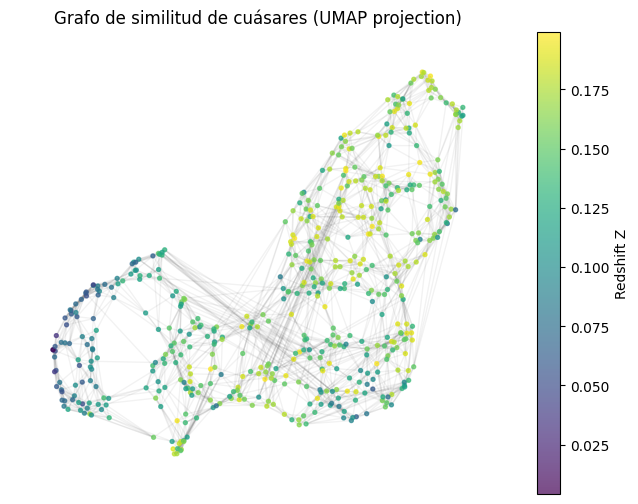

In [5]:
import umap

# Embedding 2D
embedding = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=42).fit_transform(X_scaled)

# Guardar en nodos
for i, (x, y) in enumerate(embedding):
    G.nodes[i]["pos"] = (x, y)
    G.nodes[i]["Z"] = df.loc[i, "Z"]

# Visualizar
pos = nx.get_node_attributes(G, "pos")
z = np.array([G.nodes[i]["Z"] for i in G.nodes])

plt.figure(figsize=(8, 6))
nx.draw_networkx_edges(G, pos, alpha=0.05)
plt.scatter(
    [p[0] for p in pos.values()],
    [p[1] for p in pos.values()],
    c=z, cmap="viridis", s=8, alpha=0.7
)
plt.colorbar(label="Redshift Z")
plt.title("Grafo de similitud de cuásares (UMAP projection)")
plt.axis("off")
plt.show()

In [6]:
degrees = np.array([deg for _, deg in G.degree()])
print(f"Grado medio: {degrees.mean():.2f} ± {degrees.std():.2f}")
print(f"Número de componentes: {nx.number_connected_components(G)}")


Grado medio: 10.42 ± 2.09
Número de componentes: 3


In [7]:
import community as community_louvain
import matplotlib.cm as cm

Nº de comunidades: 13
Tamaño de las 10 mayores:
 12    82
2     78
4     51
9     48
10    47
7     45
5     45
6     40
11    39
8     38
Name: count, dtype: int64


C:\Users\jm_ra\AppData\Local\Temp\ipykernel_19564\3441995946.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", max(n_comm, 3))  # tab20 da hasta 20 colores; para más, puedes usar tab20 + hsv


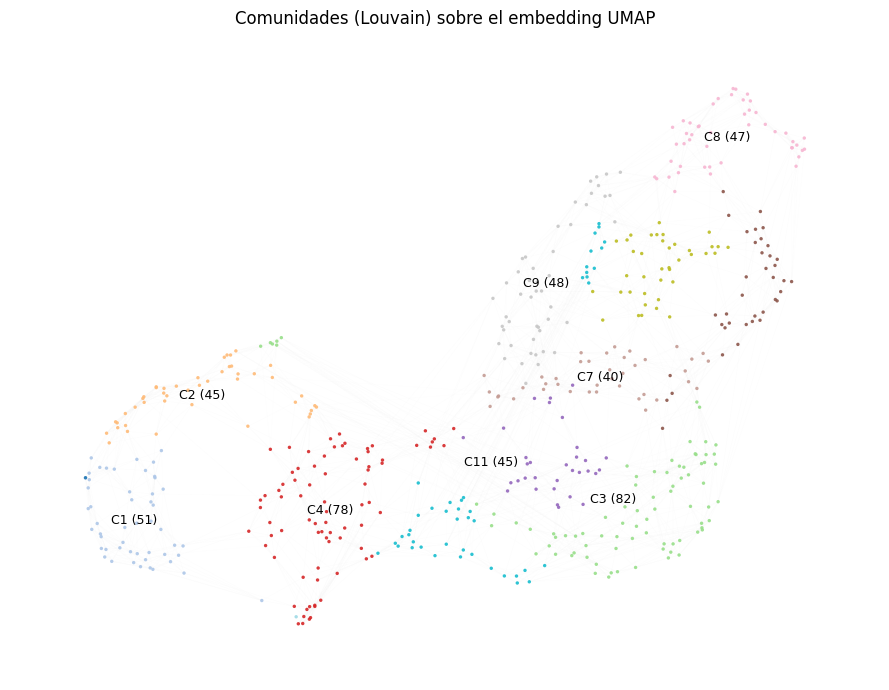

In [8]:
partition = community_louvain.best_partition(
    G,
    weight="weight" if nx.get_edge_attributes(G, "weight") else None,
    resolution=1.0,          # ↑ sube para más comunidades, ↓ para menos
    random_state=42
)
nx.set_node_attributes(G, partition, "comm")

# 2) Estadísticas rápidas
comm_id = np.array([partition[i] for i in G.nodes()])
sizes = pd.Series(comm_id).value_counts().sort_values(ascending=False)
print(f"Nº de comunidades: {sizes.size}")
print("Tamaño de las 10 mayores:\n", sizes.head(10))

# 3) Reordenar colores por <Z> (opcional, solo para que el color tenga sentido físico)
order = (
    pd.Series(z)
    .groupby(comm_id)
    .mean()
    .sort_values()
    .index
)
remap = {old:new for new, old in enumerate(order)}
comm_ord = np.array([remap[c] for c in comm_id])

# 4) Paleta discreta con suficientes colores
n_comm = sizes.size
cmap = cm.get_cmap("tab20", max(n_comm, 3))  # tab20 da hasta 20 colores; para más, puedes usar tab20 + hsv

# 5) Dibujo
plt.figure(figsize=(9,7))
nx.draw_networkx_edges(G, pos, alpha=0.05, width=0.3, edge_color="lightgray")

xy = np.array([pos[i] for i in G.nodes()])
plt.scatter(xy[:,0], xy[:,1],
            c=comm_ord, cmap=cmap, s=6, alpha=0.9, linewidths=0)

plt.title("Comunidades (Louvain) sobre el embedding UMAP")
plt.axis("off")

# 6) Etiquetar centroides de las comunidades más grandes
top_k = min(8, n_comm)
for cid in sizes.index[:top_k]:
    idx = np.where(comm_id == cid)[0]
    cx, cy = xy[idx].mean(axis=0)
    plt.text(cx, cy, f"C{remap[cid]} ({len(idx)})", ha="center", va="center", fontsize=9)

plt.tight_layout()
plt.show()

In [9]:
import numpy as np, pandas as pd, networkx as nx
from community import modularity  # python-louvain

# Asumo: df (tus datos), G (grafo), 'comm' en atributos de nodos, pos y z ya calculados
comm = pd.Series(nx.get_node_attributes(G, "comm")).sort_index()
df_comm = df.copy()
df_comm["comm"] = comm.values

# Modularidad
part_dict = dict(comm.items())
Q = modularity(part_dict, G, weight="weight" if nx.get_edge_attributes(G,"weight") else None)
print(f"Modularidad (Louvain): {Q:.3f}")

# Resumen por comunidad
cols = ["Z","u_g","g_r","r_i","M_u","M_g","M_r","M_i","SN_MEDIAN_ALL"]
summary = (df_comm
           .groupby("comm")[cols]
           .agg(["count","mean","std"])
           .sort_values(("Z","mean")))
print(summary.head(10))


Modularidad (Louvain): 0.735
         Z                       u_g                       g_r            \
     count      mean       std count      mean       std count      mean   
comm                                                                       
1        1  0.004153       NaN     1  0.284963       NaN     1  0.167753   
4       51  0.089126  0.028627    51  1.232637  0.312466    51  0.965889   
5       45  0.094632  0.030980    45  0.406476  0.150908    45  0.538042   
12      82  0.135782  0.035572    82  0.287110  0.147864    82  0.379738   
2       78  0.141768  0.027949    78  0.676399  0.284667    78  0.732649   
0       32  0.149320  0.027803    32  0.262983  0.088785    32  0.427707   
8       38  0.149782  0.029619    38  0.117820  0.077085    38  0.232589   
6       40  0.152250  0.027781    40  0.121899  0.064093    40  0.321175   
10      47  0.160820  0.025050    47  0.130447  0.132782    47  0.249158   
9       48  0.161778  0.022993    48  0.107994  0.093481   

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

features = ["M_u","M_g","M_r","M_i","u_g","g_r","r_i"]
X = df[features].values
Z = df[["Z"]].values

# Residualizar cada feature respecto a Z (modelo lineal simple)
X_res = np.empty_like(X)
for j in range(X.shape[1]):
    lr = LinearRegression().fit(Z, X[:,j])
    X_res[:,j] = X[:,j] - lr.predict(Z).ravel()

# Escalar y reconstruir kNN + UMAP + Louvain con X_res


In [11]:
from sklearn.metrics import normalized_mutual_info_score as NMI

# comm_a, comm_b son arrays alineados por nodo
score = NMI(comm_a, comm_b)
print("NMI:", score)


NameError: name 'comm_a' is not defined

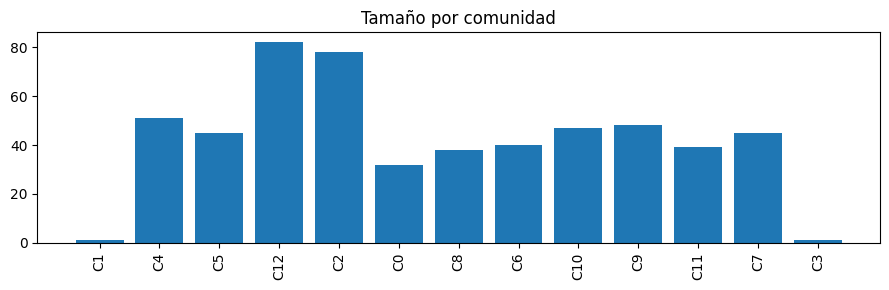

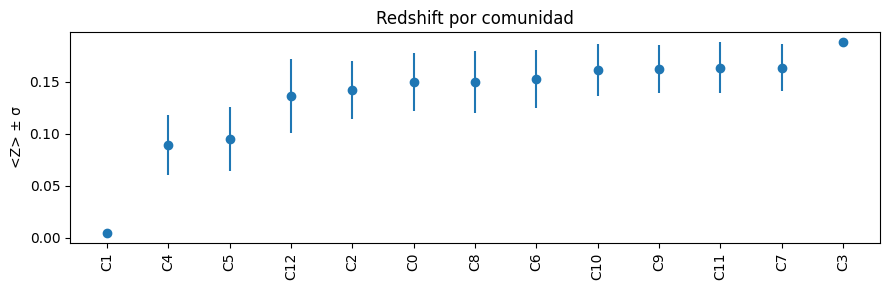

In [12]:
import matplotlib.pyplot as plt

sizes = df_comm["comm"].value_counts().sort_index()
z_mean = df_comm.groupby("comm")["Z"].mean().reindex(sizes.index)
z_std  = df_comm.groupby("comm")["Z"].std().reindex(sizes.index)

order = z_mean.sort_values().index
plt.figure(figsize=(9,3))
plt.bar(range(len(order)), sizes.loc[order].values)
plt.xticks(range(len(order)), [f"C{i}" for i in order], rotation=90)
plt.title("Tamaño por comunidad"); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,3))
plt.errorbar(range(len(order)), z_mean.loc[order], yerr=z_std.loc[order], fmt="o")
plt.xticks(range(len(order)), [f"C{i}" for i in order], rotation=90)
plt.ylabel("<Z> ± σ"); plt.title("Redshift por comunidad"); plt.tight_layout(); plt.show()


In [48]:
df_out = df.copy()
df_out["comm"] = comm.values
df_out.to_csv("../results/tables/dr16q_with_communities.csv", index=False)